In [14]:
import pickle
from pathlib import Path
from time import time
from collections import namedtuple
from itertools import repeat
from functools import partial

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision.datasets import CIFAR10
import torchvision.transforms as tf

#from torchsummary import summary

from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import numpy as np
import PIL.Image

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
PATH = "../dataset/cifar-10-batches-py"

In [31]:
class CUDADataLoader:
    def __init__(self, dataloader):
        self.dataloader = dataloader
        
    def __iter__(self):
        for images, labels in self.dataloader:
            yield [images.to(device), labels.to(device)]
            
    def __len__(self):
        return len(self.dataloader)
    
    @property
    def dataset(self):
        return self.dataloader.dataset

class CIFAR10Dataset:
    def __init__(self, dataset='train', path=PATH):
        path = Path(path)
        if dataset == 'train':
            batches = [self.load_batch(p) for p in path.glob('data_batch_*')]
            self.images = torch.cat([b for b, _ in batches])
            self.labels = torch.cat([b for _, b in batches])
        elif dataset == 'test':
            self.images, self.labels = self.load_batch(path / 'test_batch')
            
        # normalize
        self.images = self.images.float()
        self.labels = self.labels.long()
        
        std, mean = torch.std_mean(self.images, dim=0)
        self.images = (self.images - mean) / std
        
        assert len(self.images) == len(self.labels)
    
    def load_batch(self, path):
        with open(path, 'rb') as file:
            data_dict = pickle.load(file, encoding='bytes')
        images = data_dict[b'data'].reshape((-1, 32, 32, 3), order='F').swapaxes(1,3)
        images = torch.from_numpy(images)
        labels = torch.Tensor(data_dict[b'labels'])
        return images, labels
    
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, index):
        return self.images[index], self.labels[index]

In [16]:
class TrainProgressBar:
    def __init__(self):
        self._runs_bar = self._epoch_bar = self._batch_bar = None
        self._initialized = False
        
    def _initialize_bars(self, init_runs):
        if not self._initialized:
            if init_runs:
                self._runs_bar = tqdm(desc="runs")
            self._epoch_bar = tqdm(desc="epochs")
            self._batch_bar = tqdm(desc="batches")
            self._initialized = True
        
    @staticmethod
    def _get_len(it):
        try:
            return len(it)
        except TypeError:
            return -1
        
    @staticmethod
    def _decorate_iterator(it, pbar):
        pbar.reset(total=TrainProgressBar._get_len(it))
        
        for item in it:
            yield item
            pbar.update(1)
            
    def runs(self, iterator):
        length = TrainProgressBar._get_len(iterator)
        self._initialize_bars(init_runs=True)
        yield from TrainProgressBar._decorate_iterator(iterator, self._runs_bar)
        
    def epochs(self, iterator):
        self._initialize_bars(init_runs=False)
        yield from TrainProgressBar._decorate_iterator(iterator, self._epoch_bar)
        
    def batches(self, iterator):
        yield from TrainProgressBar._decorate_iterator(iterator, self._batch_bar)
        
    def write(self, text):
        self._batch_bar.write(text)
        
    def close(self):
        if self._runs_bar is not None:
            self._runs_bar.close()
        self._epoch_bar.close()
        self._batch_bar.close()
        
    def __enter__(self):
        return self
    
    def __exit__(self, *exc):
        self.close()

In [41]:
def predictions_to_hits(predictions, labels):
    return predictions.argmax(dim=1).eq(labels).count_nonzero()

def train(model, optimizer, train_dataloader, test_dataloader=None,
          loss_fn=None, reg_fn=None, num_epochs=25, pbar=None):
    
    # init outputs and progressbar
    
    losses = torch.zeros(num_epochs)
    train_accuracies = torch.zeros(num_epochs)
    test_accuracies = torch.zeros(num_epochs)
    
    for epoch in pbar.epochs(range(num_epochs)):
        
        # init variables
        
        epoch_losses = torch.zeros(len(train_dataloader)).to(device)
        hits = torch.zeros(1).to(device)
        total = torch.zeros(1).to(device)
        
        # train model
        
        model.train(True)
        
        for i, (images, labels) in enumerate(pbar.batches(train_dataloader)):
            optimizer.zero_grad()
            predictions = model(images)
            loss = loss_fn(predictions, labels)
            
            if(reg_fn):
                loss += reg_fn()
            
            loss.backward()
            optimizer.step()
            
            epoch_losses[i] = loss
            hits += predictions_to_hits(predictions, labels)
            total += len(images)
        
        losses[epoch] = torch.mean(epoch_losses)
        train_accuracies[epoch] = hits / total
        
        # get test accuracy
        
        model.train(False)
        
        if test_dataloader is not None:
            hits[:] = total[:] = 0
            for images, labels in pbar.batches(test_dataloader):
                predictions = model(images)
                hits += predictions_to_hits(predictions, labels)
                total += len(images)
            
        test_accuracies[epoch] = hits / total
        
        # update pbar
        
        pbar.write(f"[{epoch+1:>2}/{num_epochs}] "
                   f"train_accuracy: {train_accuracies[epoch]:.4f}, "
                   f"test_accuracy: {test_accuracies[epoch]:.4f}, "
                   f"loss: {losses[epoch]:.4f}")
    
    return tuple(a.detach().numpy() for a in (losses, train_accuracies, test_accuracies))

In [18]:
Results = namedtuple("Results", "losses train_accuracies test_accuracies")

def plot_results(names, results, title=""):
    _, axs = plt.subplots(1,2,figsize=(14,7))
    
    axs[0].set_xlabel('epochs')
    axs[0].set_ylabel('loss')
    
    axs[1].set_xlabel('epochs')
    axs[1].set_ylabel('accuracy')
    
    for name, result in zip(names, results):
        a, *_ = axs[0].plot(result.losses, label=name)
        axs[1].plot(result.test_accuracies, label=name+" (test)", color=a.get_color())
        axs[1].plot(result.train_accuracies, label=name+" (train)", color=a.get_color(), linestyle='dotted')

    axs[0].legend()
    axs[1].legend()
    
    plt.suptitle(title)
    plt.tight_layout()
    plt.show()

In [32]:
results = dict()
train_dataloader = CUDADataLoader(DataLoader(CIFAR10Dataset('train', PATH),
                                  batch_size=64, shuffle=True, pin_memory=False))
test_dataloader = CUDADataLoader(DataLoader(CIFAR10Dataset('test', PATH),
                                  batch_size=64, shuffle=False, pin_memory=False))

# (a) A small residual network

In [44]:
class ResBlock(nn.Module):
    def __init__(self, feature_in, feature_out, stride=1):
        super(ResBlock, self).__init__()
        self.block = nn.Sequential(
            nn.Conv2d(feature_in, feature_out, kernel_size=3, stride=stride, padding=1, bias=False),
            nn.BatchNorm2d(feature_out),
            
            nn.ReLU(),
            
            nn.Conv2d(feature_out, feature_out, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(feature_out)
        )
        self.shortcut = nn.Sequential()
        if stride != 1 or feature_in != feature_out:
            self.shortcut = nn.Sequential(
                nn.Conv2d(feature_in, feature_out, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(feature_out)
            )
    
    def forward(self, x):
        output = self.block(x)
        output += self.shortcut(x)
        output = F.relu(output)
        return output

In [67]:
bn_factory = partial(nn.BatchNorm1d, affine=False, momentum=0.1)
class ResNet(nn.Module):
    def __init__(self, in_channels, num_classes, num_resblocks):
        super(ResNet, self).__init__()
        
        num_blocks = len(num_resblocks)
        
        layers = []
        for i in range(num_blocks-1):
            layers.append(ResBlock(num_resblocks[i], num_resblocks[i]))
            layers.append(nn.Conv2d(num_resblocks[i], num_resblocks[i+1], kernel_size=3, padding=1, bias=False))
            nn.BatchNorm2d(num_resblocks[i+1])
            layers.append(nn.ReLU())
        
        layers.append(ResBlock(num_resblocks[num_blocks-1], num_resblocks[num_blocks-1]))
        layers.append(nn.AvgPool2d((2,2)))
        # dense
        layers.append(nn.Flatten())
        layers.append(nn.Linear(8192,10))
        
        self.blocks = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=7, stride=2, padding=3, bias=False),
            nn.BatchNorm2d(32),
            nn.ReLU(),  
            *layers
        ).to(device)   
    

    def forward(self, x):
        x = self.blocks(x)
        return x

### base model

In [27]:
def make_cnn_model(activation_factory, use_batch_normalization=False):
    bn_factory = partial(nn.BatchNorm2d) if use_batch_normalization else nn.Identity
    
    return nn.Sequential(
        ### first block ###
        
        nn.Conv2d(3,32,(3,3)),
        bn_factory(32),
        activation_factory(),
        
        nn.Conv2d(32,32,(3,3)),
        bn_factory(32),
        activation_factory(),
        
        nn.MaxPool2d((2,2)),
        
        ### second block ###
        
        nn.Conv2d(32,64,(3,3)),
        bn_factory(64),
        activation_factory(),
        
        nn.Conv2d(64,64,(3,3)),
        bn_factory(64),
        activation_factory(),
        
        nn.MaxPool2d((2,2)),
        
        ### dense layer ###
        
        nn.Flatten(),
        nn.Linear(1600,10)
    ).to(device)


In [33]:
model = make_cnn_model(activation_factory=nn.ReLU)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0005, betas=(0.9, 0.95), weight_decay=0)

with TrainProgressBar() as pbar:
    results["cnn"] = Results(*train(model, optimizer, train_dataloader, test_dataloader,
                                            loss_fn=F.cross_entropy, reg_fn=None, num_epochs=25, pbar=pbar))

[ 1/25] train_accuracy: 0.4301, test_accuracy: 0.5180, loss: 1.5702
[ 2/25] train_accuracy: 0.5651, test_accuracy: 0.6044, loss: 1.2379
[ 3/25] train_accuracy: 0.6311, test_accuracy: 0.6511, loss: 1.0672
[ 4/25] train_accuracy: 0.6716, test_accuracy: 0.6751, loss: 0.9430
[ 5/25] train_accuracy: 0.7036, test_accuracy: 0.6697, loss: 0.8588
[ 6/25] train_accuracy: 0.7277, test_accuracy: 0.7005, loss: 0.7905
[ 7/25] train_accuracy: 0.7487, test_accuracy: 0.7206, loss: 0.7318
[ 8/25] train_accuracy: 0.7586, test_accuracy: 0.7381, loss: 0.6920
[ 9/25] train_accuracy: 0.7771, test_accuracy: 0.7448, loss: 0.6513
[10/25] train_accuracy: 0.7877, test_accuracy: 0.7368, loss: 0.6214
[11/25] train_accuracy: 0.7994, test_accuracy: 0.7428, loss: 0.5826
[12/25] train_accuracy: 0.8076, test_accuracy: 0.7469, loss: 0.5574
[13/25] train_accuracy: 0.8170, test_accuracy: 0.7370, loss: 0.5282
[14/25] train_accuracy: 0.8263, test_accuracy: 0.7532, loss: 0.5025
[15/25] train_accuracy: 0.8331, test_accuracy: 0

In [68]:
model = ResNet(in_channels=3, num_classes=10, num_resblocks=[32,64,128])
optimizer = torch.optim.Adam(model.parameters(), lr=0.0005, betas=(0.9, 0.95), weight_decay=0)

with TrainProgressBar() as pbar:
    results["resnet"] = Results(*train(model, optimizer, train_dataloader, test_dataloader,
                                            loss_fn=F.cross_entropy, reg_fn=None, num_epochs=25, pbar=pbar))

[ 1/25] train_accuracy: 0.5218, test_accuracy: 0.6364, loss: 1.3386
[ 2/25] train_accuracy: 0.6698, test_accuracy: 0.6957, loss: 0.9380
[ 3/25] train_accuracy: 0.7270, test_accuracy: 0.6934, loss: 0.7751
[ 4/25] train_accuracy: 0.7678, test_accuracy: 0.7297, loss: 0.6613
[ 5/25] train_accuracy: 0.8026, test_accuracy: 0.7308, loss: 0.5663
[ 6/25] train_accuracy: 0.8276, test_accuracy: 0.7564, loss: 0.4924
[ 7/25] train_accuracy: 0.8520, test_accuracy: 0.7639, loss: 0.4253
[ 8/25] train_accuracy: 0.8731, test_accuracy: 0.7640, loss: 0.3608
[ 9/25] train_accuracy: 0.8913, test_accuracy: 0.7640, loss: 0.3079
[10/25] train_accuracy: 0.9081, test_accuracy: 0.7659, loss: 0.2592
[11/25] train_accuracy: 0.9218, test_accuracy: 0.7664, loss: 0.2166
[12/25] train_accuracy: 0.9355, test_accuracy: 0.7638, loss: 0.1830
[13/25] train_accuracy: 0.9426, test_accuracy: 0.7654, loss: 0.1588
[14/25] train_accuracy: 0.9512, test_accuracy: 0.7771, loss: 0.1404
[15/25] train_accuracy: 0.9563, test_accuracy: 0

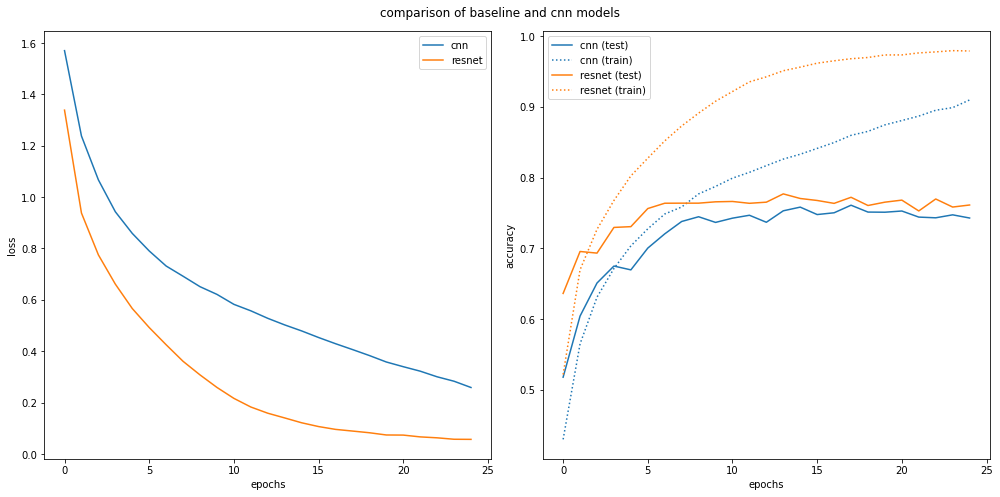

In [70]:
names = ['cnn', 'resnet']
plot_results(names, [results[n] for n in names], title="comparison of baseline and cnn models")